## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [ ]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, HoltWinters
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse, rel_mse, mqloss
from hierarchicalforecast.methods import TopDown, BottomUp
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

import pickle
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
from qgridnext import show_grid
from importlib import reload

In [ ]:
reload( hierarchicalforecast.evaluation)

In [ ]:
TEST_PERIODS = 4

In [ ]:
Y_df_load = (
    pd.read_parquet("revenue_data.parquet").rename({"value": "y"}, axis=1).reset_index()
)


Y_df_load['y'] = Y_df_load['y'] / 1e6  # make everything in millions so its easier to read

## Prep Data

In [ ]:
# last date
last_date = pd.to_datetime(date(2023, 9, 30))

In [ ]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [ ]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [ ]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [ ]:
# Get rid of companies for which we do not have enough data
MINIMUM_NUMBER_OF_OBSERVATIONS = 40
Y_df_load = Y_df_load.groupby("ticker").filter(
    lambda x: x.shape[0] > MINIMUM_NUMBER_OF_OBSERVATIONS
)

In [ ]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [ ]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [ ]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [ ]:
Y_df_load["entity_type"] = "company"

## Build training data

In [121]:
levels = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "ticker"],
]

levels = [
    ['top_level_SIC_code'],
    
    ["top_level_SIC_code", "second_level_SIC_code"],
    ['top_level_SIC_code',"second_level_SIC_code", 'ticker'],
]
"""
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]
"""

'\n    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],\n    [\n        "entity_type",\n        "top_level_SIC_code",\n        "second_level_SIC_code",\n        "third_level_SIC_code",\n    ],\n    [\n        "entity_type",\n        "top_level_SIC_code",\n        "second_level_SIC_code",\n        "third_level_SIC_code",\n        "fourth_level_SIC_code",\n    ],\n    [\n        "entity_type",\n        "top_level_SIC_code",\n        "second_level_SIC_code",\n        "third_level_SIC_code",\n        "fourth_level_SIC_code",\n        "ticker",\n    ],\n]\n'

In [122]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=levels)

In [123]:
Y_df = Y_df.reset_index()

In [124]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [126]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4), Naive()], freq="QE", n_jobs=-1)

In [127]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


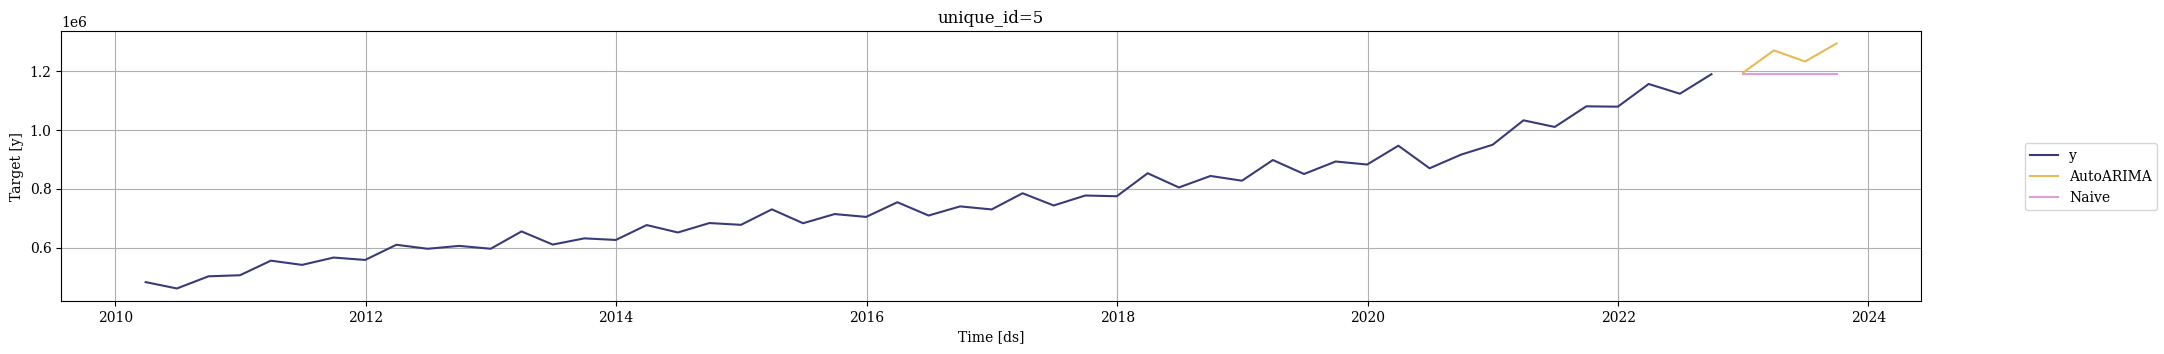

In [128]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA", "Naive"],
    unique_ids=["5"],
)

## Hierarchical reconciliation

In [129]:
hrec = HierarchicalReconciliation(reconcilers=[BottomUp()])

In [130]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [131]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

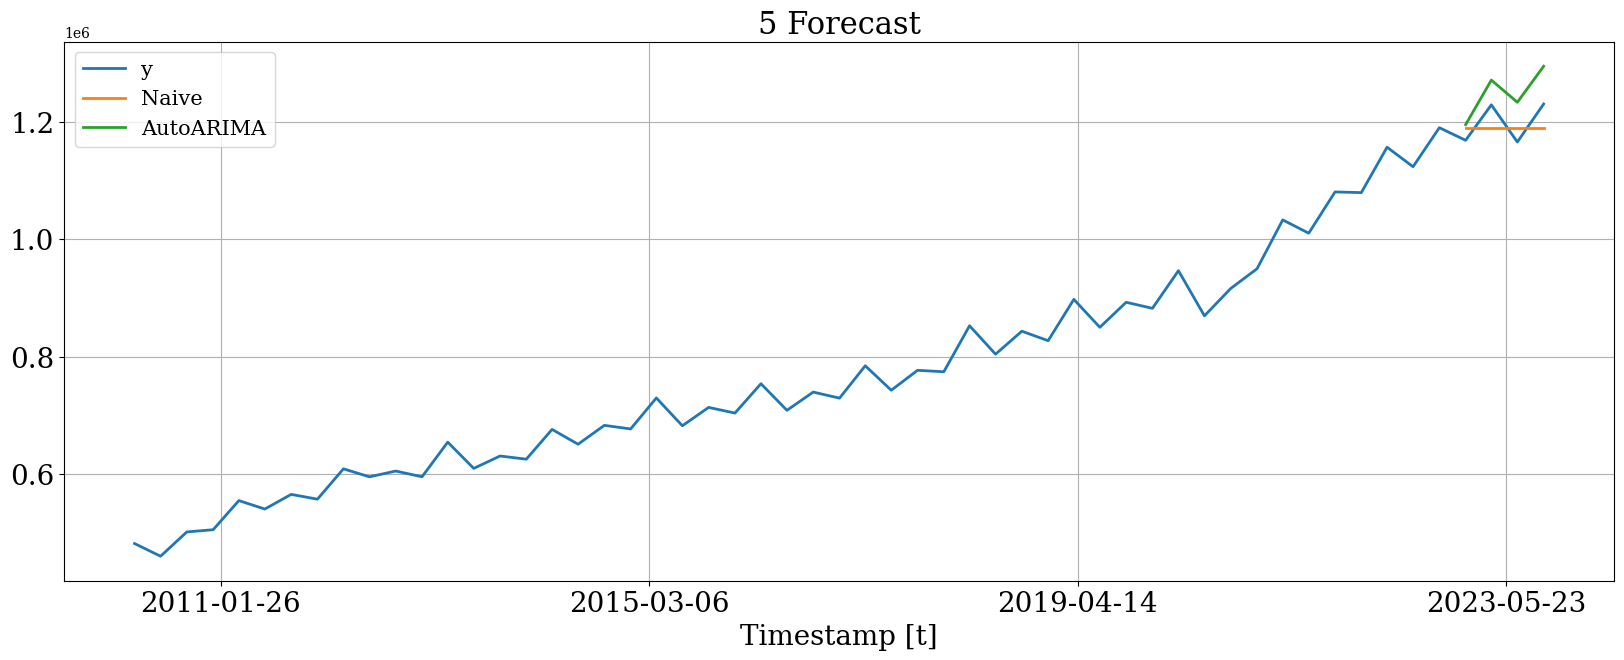

In [132]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_series(
    series="5",
    Y_df=plot_df,
    models=["y", "Naive", "AutoARIMA"],
    level=[80],
)

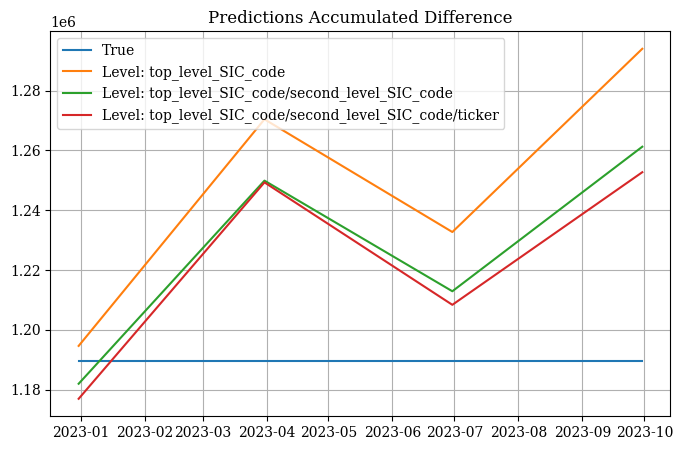

In [134]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [135]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    Y_df=Y_train_df,
    tags=tags,
    benchmark="Naive",
)

In [136]:
evaluation.T

level,Overall,top_level_SIC_code,top_level_SIC_code/second_level_SIC_code,top_level_SIC_code/second_level_SIC_code/ticker
metric,mse-scaled,mse-scaled,mse-scaled,mse-scaled
AutoARIMA,1.152841,2.667046,0.251517,0.322932
Naive,1.0,1.0,1.0,1.0
AutoARIMA/BottomUp,0.46125,0.695456,0.32944,0.322932
Naive/BottomUp,1.000002,1.000004,1.000001,1.0


In [ ]:
S_df